In [114]:
import numpy as np
import logging
#logging.getLogger("imperative_model").setLevel(logging.DEBUG)
#logging.basicConfig(level=logging.DEBUG)

In [115]:
%run repl_load_model.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
obj {rdflib.term.URIRef('http://ukfires.org/probs/system/AmmoniumNitrate'), rdflib.term.URIRef('http://ukfires.org/probs/system/Nitrogen'), rdflib.term.URIRef('http://ukfires.org/probs/system/Water'), rdflib.term.URIRef('http://ukfires.org/probs/system/Hydrogen'), rdflib.term.URIRef('http://ukfires.org/probs/system/AtmoshericCO2'), rdflib.term.URIRef('http://ukfires.org/probs/system/Urea'), rdflib.term.URIRef('http://ukfires.org/probs/system/NaturalGas'), rdflib.term.URIRef('http://ukfires.org/probs/system/PureOxygen'), rdflib.term.URIRef('http://ukfires.org/probs/system/Coal'), rdflib.term.URIRef('http://ukfires.org/probs/system/NitricAcid'), rdflib.term.URIRef('http://ukfires.org/probs/system/OtherIndustrialGases'), rdflib.term.URIRef('http://c-thru.org/analyses/calculator/system/CO2'), rdflib.term.URIRef('http://ukfires.org/probs/system/CO2'), rdflib.term.URIRef('http://ukfires.org/probs/system/A

Define a demand profile for the fertilisers

In [121]:
tvals = np.arange(2020, 2051, 1)
tvals

array([2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030,
       2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041,
       2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050])

In [122]:
t = sy.symbols("t")
t

t

In [123]:
def linear_ramp(t1, t2, y1, y2):
    frac = sy.Min(1, sy.Max(0, (t - t1) / (t2 - t1)))
    return y1 + frac * (y2 - y1)

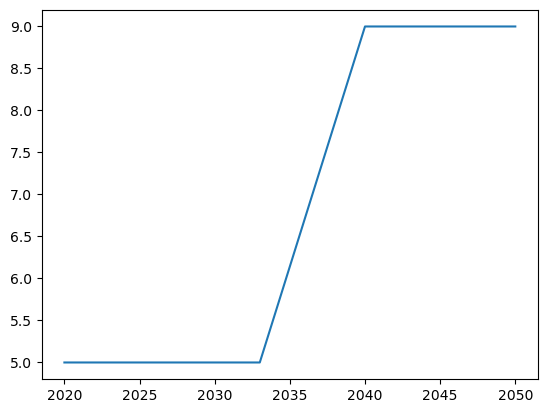

In [124]:
import matplotlib.pyplot as plt
plt.plot(tvals, np.vectorize(sy.lambdify(t, linear_ramp(2033, 2040, 5, 9)))(tvals))

In [126]:
linear_ramp(2033, 2040, 5, 9).subs({t: 2050})

9

In [149]:
import pandas as pd
level_data = pd.read_excel("levers.xlsx", header=[0, 1], index_col=[0, 1], sheet_name="Levels")
constants = pd.read_excel("levers.xlsx", header=[0], index_col=[0], sheet_name="Constants")

In [150]:
level_data

Unnamed: 2_level_0 Unnamed: 3_level_0 Level 1           \
Symbol                       Description              Units      y1 y2    t1   
Fertiliser demand Z_1    Demand for Urea                 kg       5  6  2020   

                            Level 2                Level 3                 \
Symbol                   t2      y1 y2    t1    t2      y1 y2    t1    t2   
Fertiliser demand Z_1  2050       5  7  2020  2040       5  9  2020  2040   

                      Level 4                 
Symbol                     y1 y2    t1    t2  
Fertiliser demand Z_1       5  9  2020  2030

In [151]:
constants

,Description,Units,Value
Symbol,,,
Z_2,Demand for AmmoniumNitrate,kg,7.0
a_1,H2 Coal Fraction,-,0.3


In [152]:
def data_from_levers(levels):
    result = {}
    # XXX don't have to do this every time
    for symbol, row in constants.iterrows():
        result[symbol] = row["Value"]
    for (lever, symbol), row in level_data.iterrows():
        if lever in levels:
            values = row[f"Level {levels[lever]}"]
            func = linear_ramp(values.t1, values.t2, values.y1, values.y2)
            result[symbol] = func
    return result

In [153]:
data_from_levers({"Fertiliser demand": 4})

{'Z_2': 7.0, 'a_1': 0.3, 'Z_1': 4*Min(1, Max(0, t/10 - 202)) + 5}

In [154]:
flows = solution_to_flows(model, {**data_from_levers({"Fertiliser demand": 4}),
                                  t: 2020})
flows

,source,target,material,value
0,AmmoniaSynthesis,Ammonia,Ammonia,5.87500000000000
1,ExtractCO2FromAtmosphere,CO2,CO2,0.812500000000000
2,HydrogenSynthesisFromCoal,CO2,CO2,0.881250000000000
3,HydrogenSynthesisFromCoal,Hydrogen,Hydrogen,0.881250000000000
4,HydrogenSynthesisFromNaturalGas,Hydrogen,Hydrogen,2.05625000000000
5,HydrogenSynthesisFromNaturalGas,CO2,CO2,2.05625000000000
6,ProducingNitricAcid,Water,Water,2.36250000000000
7,ProducingNitricAcid,NitricAcid,NitricAcid,5.51250000000000
8,ProducingUrea,Water,Water,1.50000000000000
9,ProducingUrea,OtherIndustrialGases,OtherIndustrialGases,0.150000000000000


In [155]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout
w = SankeyWidget(links=flows.to_dict(orient='records'), layout=Layout(width="1200", height="300"))
w.order = [
    ["NaturalGas", "Coal", "AtmosphericCO2"],
    ["HydrogenSynthesisFromNaturalGas", "HydrogenSynthesisFromCoal", "ExtractCO2FromAtmosphere"],
    ["Hydrogen", "CO2", "Nitrogen", "PureOxygen"],
    ["AmmoniaSynthesis", "ProducingNitricAcid"],
    ["Ammonia", "NitricAcid"],
    ["ProducingUrea", "ProducingAmmoniumNitrate"],
    ["Urea", "AmmoniumNitrate", "Water", "OtherIndustrialGases", "WasteOtherChemicals",],
]
w

SankeyWidget(layout=Layout(height='300', width='1200'), links=[{'source': 'AmmoniaSynthesis', 'target': 'Ammon…

In [156]:
from ipywidgets import interact

@interact(d1=(0., 10.), d2=(0., 10.), a3=(0., 1.), ti=(2020., 2050.))
def calc_flows(d1=5.0, d2=5.0, a3=0.5, ti=2020):
    d1t = linear_ramp(2030, 2040, 5, d1)
    flows = solution_to_flows(model, {demand_symbols["Urea"]: d1t, demand_symbols["AmmoniumNitrate"]: d2, h2_coal_fraction: a3, t: ti})
    w.links = flows.to_dict(orient='records')

interactive(children=(FloatSlider(value=5.0, description='d1', max=10.0), FloatSlider(value=5.0, description='…

In [157]:
@interact(l1=[1, 2, 3, 4], ti=(2020., 2050.))
def calc_flows_levels(l1=1, ti=2020):
    params = data_from_levers({"Fertiliser demand": l1})
    flows = solution_to_flows(model, {**params, t: ti})
    w.links = flows.to_dict(orient='records')

interactive(children=(Dropdown(description='l1', options=(1, 2, 3, 4), value=1), FloatSlider(value=2020.0, des…

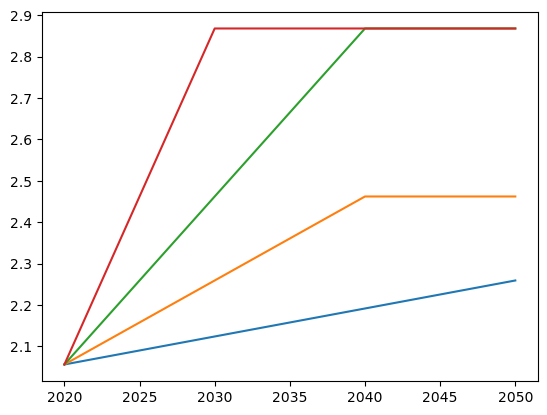

In [158]:
for i in [1, 2, 3, 4]:
    plt.plot(tvals, np.vectorize(sy.lambdify(t, post["NG demand"].subs(data_from_levers({"Fertiliser demand": i}))))(tvals))

In [37]:
from IPython.display import display

In [38]:
for j, value in model.Y.items():
    print("Process output: %s" % model.processes[j].id)
    display(value.value)
    print("History:", "\n".join(value.history))
    print("\n")

Process output: AmmoniaSynthesis


U_16*Z_2/(S_10*S_26) + U_14*U_86*Z_2/(S_10*S_26*S_84) + U_15*Z_1/(S_10*S_125)

History: set output of Ammonia from AmmoniaSynthesis = U_15*Z_1/S_125
set output of Ammonia from AmmoniaSynthesis = U_14*U_86*Z_2/(S_26*S_84)
set output of Ammonia from AmmoniaSynthesis = U_16*Z_2/S_26


Process output: ExtractCO2FromAtmosphere


Max(0, -S_42*(U_16*U_60*Z_2*a_1/(S_10*S_26*S_62) + U_14*U_60*U_86*Z_2*a_1/(S_10*S_26*S_62*S_84) + U_15*U_60*Z_1*a_1/(S_10*S_125*S_62)) - S_43*(U_16*U_60*Z_2*(1 - a_1)/(S_10*S_26*S_63) + U_14*U_60*U_86*Z_2*(1 - a_1)/(S_10*S_26*S_63*S_84) + U_15*U_60*Z_1*(1 - a_1)/(S_10*S_125*S_63)) + U_45*Z_1/S_125)/S_41

History: additional production to balance CO2


Process output: HydrogenSynthesisFromCoal


U_16*U_60*Z_2*a_1/(S_10*S_26*S_62) + U_14*U_60*U_86*Z_2*a_1/(S_10*S_26*S_62*S_84) + U_15*U_60*Z_1*a_1/(S_10*S_125*S_62)

History: set output of Hydrogen from HydrogenSynthesisFromCoal = U_15*U_60*Z_1*a_1/(S_10*S_125)
set output of Hydrogen from HydrogenSynthesisFromCoal = U_14*U_60*U_86*Z_2*a_1/(S_10*S_26*S_84)
set output of Hydrogen from HydrogenSynthesisFromCoal = U_16*U_60*Z_2*a_1/(S_10*S_26)


Process output: HydrogenSynthesisFromNaturalGas


U_16*U_60*Z_2*(1 - a_1)/(S_10*S_26*S_63) + U_14*U_60*U_86*Z_2*(1 - a_1)/(S_10*S_26*S_63*S_84) + U_15*U_60*Z_1*(1 - a_1)/(S_10*S_125*S_63)

History: set output of Hydrogen from HydrogenSynthesisFromNaturalGas = U_15*U_60*Z_1*(1 - a_1)/(S_10*S_125)
set output of Hydrogen from HydrogenSynthesisFromNaturalGas = U_14*U_60*U_86*Z_2*(1 - a_1)/(S_10*S_26*S_84)
set output of Hydrogen from HydrogenSynthesisFromNaturalGas = U_16*U_60*Z_2*(1 - a_1)/(S_10*S_26)


Process output: ProducingNitricAcid


U_86*Z_2/(S_26*S_84)

History: set output of NitricAcid from ProducingNitricAcid = U_86*Z_2/S_26


Process output: ProducingUrea


Z_1/S_125

History: set output of Urea from ProducingUrea = Z_1


Process output: ProducingAmmoniumNitrate


Z_2/S_26

History: set output of AmmoniumNitrate from ProducingAmmoniumNitrate = Z_2


